## 1. Introduction
Decision tree là một thuật toán có giám sát rất linh hoạt, có thể sử dụng cho bài toán classification và regression. Có thể sử dụng cho các trường hợp dữ liệu phức tạp. 
Decision tree xây dựng trên cơ sở một loạt các rules được tạo khi xét từng/tổ hợp các attributes và chia dữ liệu vào các class tương ứng gọi là node.
Decision tree bắt đầu phân loại từ root node bao gồm toàn bộ tập dữ liệu và kiểm tra lần lượt các attributes để chia cây thành các nhánh
## 2. Terminology
- Root node: node gốc bao gồm toàn bộ dữ liệu
- Leaf/Terminal Node: Node cuối cùng, ko bị split nữa
- Parent and Child node: Node mà bị chia thành nhiều sub-nodes gọi là parent node, sub-nodes được gọi là child node
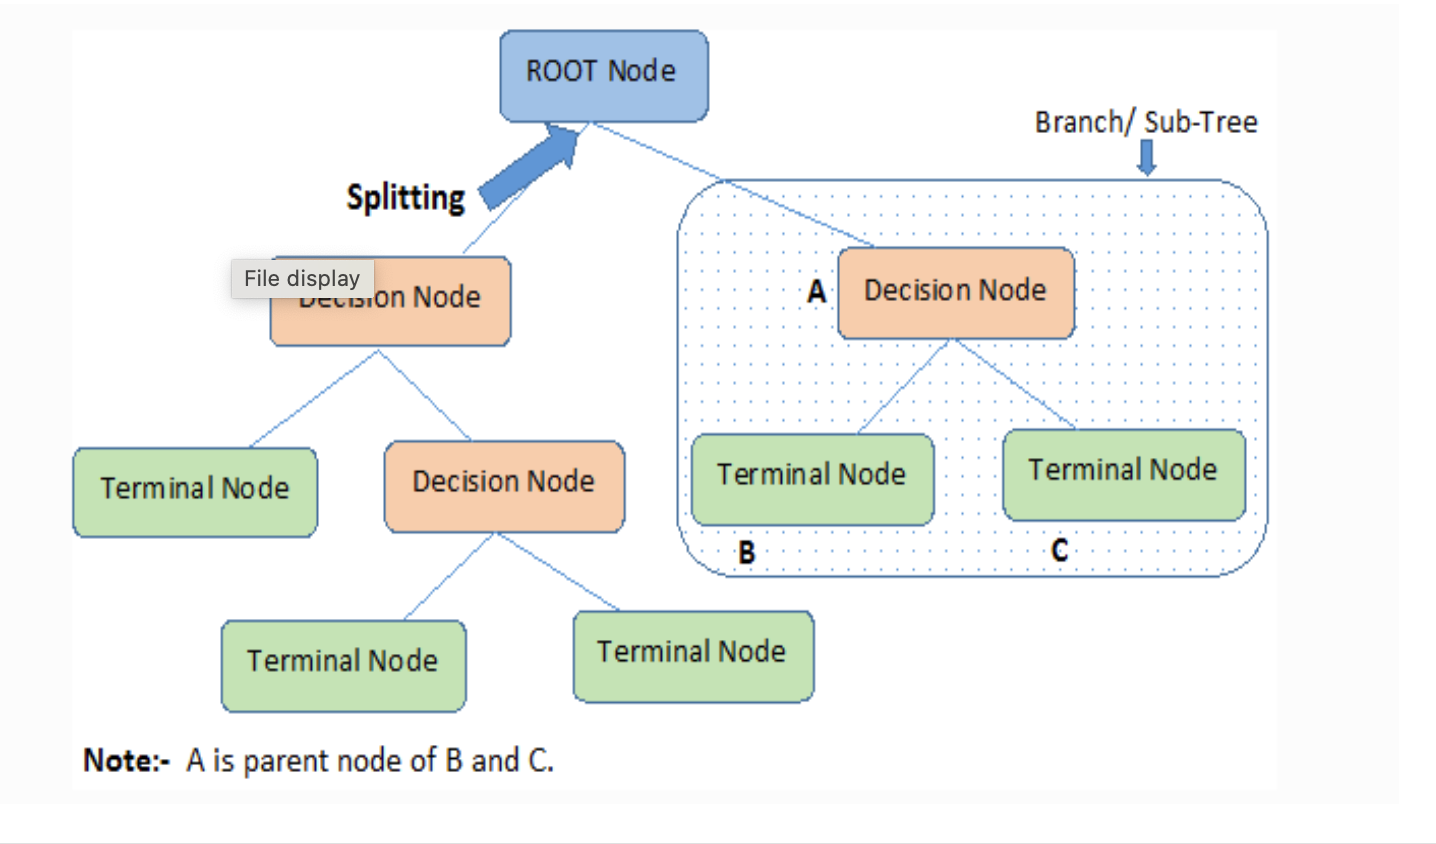

## 3. Thuật toán
Có nhiều thuật toán có thể sử dụng trong việc xây dựng mô hình cây quyết định. Trong bài này chúng ta sẽ tập chung vào thuật toán ID3 \
**Ý tưởng:** Thuật toán xây dựng cây bằng cách sử dụng  attribute tốt nhất tại từng node đo bằng Information gain. Mục tiêu của thuật toán là tạo ra các subset đồng nhất nhất có thể. Bằng cách splitting tại attribute làm giảm entropy nhất tai từng node, ID3 xây được cây hoàn chỉnh.\
1. Chọn best attribute: Sử dụng entropy và information gain để tìm attribute tốt nhất để phân tách dữ liệu. Thuật toán tính entropy tại từng node và chọn attribute có giá trị information gian lớn nhất khi dùng nó để split thành các class
2. Tạo Tree Nodes: Dùng attribute đã chọn để chia thành các subnode, tại mỗi subnode lại tiếp tục tính entropy và information gain để chọn attribute để split tiếp theo
3. Điều kiện dừng: Nếu ta tiếp tục chia node theo entropy, thì sẽ đến một lúc nào đấy moi điểm trong một node đều thuộc vào 1 class. Thường lúc này Tree sẽ rất phức tạp và dễ bị overfitting. Một số ví dụ điều kiện dừng có thể chọn: 
- Nếu node có entropy = 0 (purity max)
- Đã xét hết attribute
- Số phần tử trong node nhỏ hơn một ngưỡng nào đó
- Khoảng cách từ node đến rootnode đạt đến một giá trị nào đó (giới giạn chiều sâu của cây)
- Tổng số node đạt tới một giá trị nào đó
- Information gain nhỏ hơn một ngưỡng nào đó


## 4. Cơ sở toán
#### 4.1 Hàm số entropy
Hàm số entropy đo sự purity của phân phối trong dữ liệu. Entropy càng càng cao thì sự hỗn loạn càng lớn. Ta muốn Entropy thấp.
$$H(S) = \sum_{x \in X} p_x*log(p_x)$$
Với:
- S là tập dữ liệu đang xét
- X là số class trong tập S
- p(x) xác suất điểm dữ liệu rơi vào class x
#### 4.2 Information gain
Là reduction của entroby H khi lấy thêm thông tin về dữ liệu, ở đây là khi chọn 1 attribute để split thành các class.
$$IG(S, A) = H(S) - \sum_{t \in T}p(t)H(t) = H(S) - H(S|A)$$
Với: 
- H(S) là entropy của tập S
- T là tập subset của S khi chia theo attribute A
- p(t) là xác suất một mẫu rơi vào tập subset con t (=số mẫu trong tập t/số mẫu trong S)
- H(t) là entropy của subset t

In [1]:
import numpy as np
import pandas as pd
from statistics import mode

In [2]:
class TreeNode:
    def __init__(self, ids = None, children = [], entropy = 0, depth = 0):
        self.ids = ids #index of data point in this node
        self.children = children #list of its child node
        self.entropy = entropy 
        self.depth = depth #distance to root node
        self.order = None #keeping order by which child node is splitted into
        self.split_attribute = None #the attribute chosen to split data
        self.label = None #label of node if the code is leaf
    def set_properties(self, split_attribute, order):
        self.split_attribute = split_attribute
        self.order = order
    def set_label(self, label):
        self.label = label


In [3]:
def entropy(prob):
    prob = np.array(prob)
    zero_idx = prob.nonzero()[0]
    prob_non_zero = prob[zero_idx]
    entropy = -np.sum(prob_non_zero*np.log(prob_non_zero))
    return entropy


In [4]:
class DecisionTree:
    def __init__(self, 
                 min_gain: float = 1e-4, 
                 min_sample_split: int = 2,
                 max_depth: int = 5):
        """
        Parameter:
        min_gain: the minimum gain that split must have in order for the tree to grow
        min_sample_split: mimimum sample of node to continue split
        max_depth: maximum depth of the 
        
        """
        self.min_gain = min_gain
        self.min_sample_split = min_sample_split
        self.max_depth = max_depth 
        self.root = None
        self.N = 0
    def fit(self, data, target):
        """Function to check each node and split if necessary"""
        self.N = data.shape[0]
        self.data = data
        self.attributes = list(data)
        self.target = target
        self.labels = target.unique()
        ids = range(self.N)
        self.root = TreeNode(ids = ids, entropy=self._entropy(self.target), depth = 0)
        queue = [self.root]
        #LIFO check each root that last append on queue until there is no root left
        while queue:
            node = queue.pop()
            if node.depth < self.max_depth or node.entropy < self.min_gain:
                node.children = self._split(node)
                if not node.children:
                    self._get_label(node)
                queue += node.children
            else: 
                self._get_label(node)
    def _entropy(self, target):
        """Calculate entropy of the node S"""
        if len(target) == 0:
            return 0
        _, freq = np.unique(self.target, return_counts = True)
        prob = freq/float(freq.sum())
        return -np.sum(prob*np.log(prob))
    def _information_gain(self, node, childNode):
        """"
        Calculate information gain of a Node if splitted to ChildNode
        Parameters:
        node: parent node to be splitted
        childNode: list of lists of index of ChildNode
        target: (ndarray) label of node
        
        """
        n = len(node.ids)
        sum_entropy = 0
        for ls in childNode:
            p = len(ls)/n
            sum_entropy += p * self._entropy(ls)
        gain = node.entropy - sum_entropy
        return gain
    def _get_label(self, node):
        node.set_label(self.target[node.ids].mode()[0]) 
    def _split(self, node):
        ids = node.ids
        best_split = []
        best_gain = None
        best_attribute = None
        order = None
        sub_data = self.data.iloc[ids, :]
        for i, att in enumerate(self.attributes):
            unique_val = self.data.iloc[ids, i].unique().tolist()
            if len(unique_val) == 1: continue
            # unique_val = self.data[att].unique()
            split = []
            for val in unique_val:
                sub_data_index = sub_data.index[sub_data[att]==val].tolist()
                # split += sub_data_index
                split.append(sub_data_index)
            if min(map(len, split)) < self.min_sample_split: continue
            gain = self._information_gain(node, split)
            if gain < self.min_gain: continue
            if gain > best_gain:
                best_gain = gain
                best_split = split
                best_attribute = att
                order = unique_val
                # node.set_property(best_attribute, order)
        if best_attribute:
            node.set_property(best_attribute, order)
            childnode = [TreeNode(ids=ids, entropy=self._entropy(self.target[ids]), depth=node.depth + 1) for ids in best_split]
            return childnode

# Return empty list if no valid split was found
        return []
                # childnode = [TreeNode(ids = ids, entropy=self._entropy(self.target[ids]), depth = node.depth + 1) for ids in split]
            # return childnode
    def predict(self, new_data):
        n = new_data.shape[0]
        label = [None]*n
        for i in range(n):
            sample = new_data.iloc[i, :]
            node = self.root
            while node.children:
                val = sample[node.split_attribute]
                try:
                    child_index = node.order.index(val)
                    node = node.children[child_index]
                except ValueError:
                    node = node.children[0]
            label[i] = node.label
        return np.array(label)



In [5]:
df = pd.read_csv('weather.csv')

In [6]:
data = df.iloc[:, :4]
target = df['play']

In [7]:
model = DecisionTree()
model.fit(data, target)

In [8]:
y_pred = model.predict(data)


In [9]:
y_pred

array(['yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes', 'yes',
       'yes', 'yes', 'yes', 'yes', 'yes'], dtype='<U3')

## 5. Decision Tree in sklearn

SKlearning dùng CART algorimth, chỉ tạo ra được binary trees. 
Hàm mục tiêu của thuật toán này là:
$$J(k, t_k) = \frac{m{\text{left}}}{m}G_{\text{left}} + \frac{m{\text{right}}}{m}G_{\text{right}}$$
Với
\begin{cases}
    G_{\text{left/right}} \text{ Tính độ purity của subset} \\
    m_{\text{left/right}} \text{ là số sample the left/right subset}
\end{cases}
Độ purity của subset có thể được tính bằng Gini hoặc Entropy
$$G_i = 1 - \sum_{k=1}^{n}p_{\text{i, k}}^2$$
Với G_i là Gini tại node i, n là số class trong node i, $p_{i, k}$ là tỉ lệ class k trong node i
**Gini hay Entropy** Trong phần lớn trường hợp thì không có sự khác biệt lớn, cả hai đều tạo nên Tree giống nhau, Gini tính nhanh hơn một chút. Trong các trường hợp khác nhau, Gini bias partition lớn hơn, còn Entropy thì sẽ tạo ra cây slightly more balance 

In [28]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

In [22]:
iris = load_iris()
X = iris.data[:, 2:]
y = iris.target

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
model = DecisionTreeClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [37]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
#detail classification report
print("\nClassification report")
print(classification_report(y_test, y_pred, target_names=iris.target_names))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 1.0000

Classification report
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        10
  versicolor       1.00      1.00      1.00         9
   virginica       1.00      1.00      1.00        11

    accuracy                           1.00        30
   macro avg       1.00      1.00      1.00        30
weighted avg       1.00      1.00      1.00        30


Confusion Matrix:
[[10  0  0]
 [ 0  9  0]
 [ 0  0 11]]


## 6. Pros and Cons
#### 6.1 Pros
- Dễ hiểu, dễ giải thích, dễ visualise, dễ validate sử dụng statistical test
- Không cần data preprocessing nhiều
- Chi phí sử dụng là log của số dữ liệu
- Input có thể gồm cả numerial và categorical
- Không cần nhiều giả định ban đầu
#### 6.2 Cons
- Dễ bị overfitting, tạo ra cây có quá nhiều nhánh >> có thể dùng các pp pruning để giảm thiểu vđề này
- Có thể không ổn định vì small variance in data có thể tạo nên một cái cây hoàn toàn khác >> kỹ thuật ensemple có thể giảm thiểu vđề này
- Có thể tạo ra cây bias nếu một số class dominate. Nên balance dataset trước khi fitting.
- Tìm được cái cây optimal là một bài toán NP-complete, không có cách giải hiệu quả (polinomial time) do số cây có thể tạo ra tỉ lệ mũ với số features. Cách thường được sử dụng là greedy algorimth, tuy nhiên chỉ guarantee được local optimal. >> kỹ thuật ensemple có thể giảm thiểu vđề này.